# Sentiment Analysis on a Reddit post

In this notebook, we are going to analysis a reddit post accessed using the Python Reddit API Wrapper([PRAW](https://praw.readthedocs.io/en/latest/)).  
  
The reddit post is the **[Daily Discussion](https://www.reddit.com/r/soccer/comments/noxewu/daily_discussion/)** post from the r/soccer subreddit(a subreddit focussing on football/soccer), originally posted on 31st May 2021.

## Getting data from Reddit

In [1]:
import praw

In [2]:
import pandas as pd

In [3]:
import spacy

In [4]:
nlp = spacy.load("en_core_web_sm")

To access Reddit data through PRAW, you need certain credentials obtained using your Reddit account(namely, Client ID, Client Secret, Username, Password, and User Agent). [Read how to get these credentials here...](https://praw.readthedocs.io/en/latest/getting_started/quick_start.html)

As data like password, Client Secret etc are confidential, I have stored them in a local text file(*praw_credentials.txt*) so as to keep them hidden. When required, I will read from there and pass it into the Reddit object. You can pass the credentials directly without using any files.

In [5]:
with open("praw_credentials.txt") as f:
    credentials = f.readlines()
credentials = [x.strip() for x in credentials] 

In [6]:
reddit = praw.Reddit(client_id = credentials[0], client_secret = credentials[1], username = credentials[2], password = credentials[3], user_agent = credentials[4])

In [7]:
url = "https://www.reddit.com/r/soccer/comments/noxewu/daily_discussion/"

In [8]:
submission = reddit.submission(url=url)

Now we will access all the comments from the said post, and store it in the list *post_comments*.

In [9]:
post_comments = []

In [10]:
submission.comments.replace_more(limit=None)
for comment in submission.comments.list():
    post_comments.append(comment.body)

**NOTE** : Depending on the number of comments, the above loop can take some time. To reduce the number of comments processed, you can tinker with the 'limit' parameter. Read more about PRAW comment extraction [here](https://praw.readthedocs.io/en/latest/tutorials/comments.html).

In [11]:
post_comments = post_comments[1:]

The first comment is excluded, as it is a stickied comment which is automatically pinned to every r/soccer post. It is not of any relevance to the analysis. Based on the post, this step may not be required.

In [12]:
post_comments

['Stop calling Kante cute. He is bald out of choice, he is a menace.',
 "Even Courtois congratulated us on Twitter for winning the CL but Eden didn't, I'm convinced he would've wanted to but was afraid Chiringuito would put out another hit piece if he did so.",
 "Why hasn't Moukoko won us a World Cup yet? What a disappointment.",
 "The Euros 2020 locker room experience is gonna make Kane get out of Spurs, I'm sure of it\n\nImagine being him in the locker room and his former teammates Trippier and Walker are talking about their league titles, Bellingham and Sancho their cup win, City lads are already loaded with trophies and now friggin' Chilwell, James and Mount are boasting their CL win while TAA and Henderson join in laughing.",
 ' Guardiola mourinho and now zidane. All coaches are sick of the spanish media and the pressure there is to coach barca or madrid',
 'Didn’t see anyone talk about how shit the Marshmello and Selena Gomez bit was at the finals, absolute rubbish',
 'How quickl

## Creating a pandas DataFrame of the comments, and storing it in a .csv file

This is **OPTIONAL**. As comments can change, it is nice to keep a copy of the extracted comments locally. However it is not necessary.

In [13]:
df = pd.DataFrame(post_comments)

In [14]:
df.to_csv('reddit_comments.csv',index = False)

## Trying out Sentiment Analysis with TextBlob

Given that we have the comments in hand, let's try out sentiment analysis on them.  
  
For that, we use the *textblob* library.

In [15]:
from textblob import TextBlob

In [16]:
import numpy as np

In [17]:
df['Sentiment'] = np.nan

In [18]:
df.columns = ['Comment','Sentiment']

In [19]:
df

,Comment,Sentiment
0,Stop calling Kante cute. He is bald out of cho...,NaN
1,Even Courtois congratulated us on Twitter for ...,NaN
2,Why hasn't Moukoko won us a World Cup yet? Wha...,NaN
3,The Euros 2020 locker room experience is gonna...,NaN
4,Guardiola mourinho and now zidane. All coache...,NaN
...,...,...
5973,Righttttt,NaN
5974,"As I said, I apologised for a generalisation a...",NaN
5975,>They are not even close to the same situation...,NaN
5976,"Lmao, consciously ignoring my argument because...",NaN


We can going to assign the *Sentiment* value to each comment, using the following for loop.

In [20]:
for index, row in df.iterrows():
    comment_polarity = TextBlob(row['Comment']).sentiment.polarity
    df.at[index,'Sentiment'] = comment_polarity

In [21]:
df

,Comment,Sentiment
0,Stop calling Kante cute. He is bald out of cho...,0.500000
1,Even Courtois congratulated us on Twitter for ...,-0.050000
2,Why hasn't Moukoko won us a World Cup yet? Wha...,-0.600000
3,The Euros 2020 locker room experience is gonna...,0.525000
4,Guardiola mourinho and now zidane. All coache...,-0.357143
...,...,...
5973,Righttttt,0.000000
5974,"As I said, I apologised for a generalisation a...",-0.402083
5975,>They are not even close to the same situation...,0.000000
5976,"Lmao, consciously ignoring my argument because...",-0.150000


Now we have the *Sentiment* value assigned to each comment. But there is another problem.  
  
Sentiment Analysis using TextBlob is a great tool, but it is not perfect. It will not recognise each and every word, especially in social media comments like this where spelling mistakes and slang are very much possible. Such unrecognised words are given the sentiment value of 0.  
  
Therefore for the sake of convenience, we are going to ignore any comments with the sentiment value of 0. This is a very crude method, but it will do the job here.

In [22]:
unwanted_index = []

In [23]:
for index,row in df.iterrows():
    if row['Sentiment'] == 0.0:
        unwanted_index.append(index)

The indices of the comments with 0 sentiment value are stored in the list *unwanted_index*. 

In [24]:
len(unwanted_index)

2147

This shows that 2147 out of nearly 6000 comments had 0 sentiment value, and will thus be removed. Although the remaining 3500+ comments are more than enough for our analysis, the large number of rejected comments show the imperfection of our method. For a more formal or important purpose, some other way must be found to ensure both data accuracy, as well as minimise rejection of data.

In [25]:
final_data = df.drop(unwanted_index)

In [26]:
final_data

,Comment,Sentiment
0,Stop calling Kante cute. He is bald out of cho...,0.500000
1,Even Courtois congratulated us on Twitter for ...,-0.050000
2,Why hasn't Moukoko won us a World Cup yet? Wha...,-0.600000
3,The Euros 2020 locker room experience is gonna...,0.525000
4,Guardiola mourinho and now zidane. All coache...,-0.357143
...,...,...
5971,Learn to be less arrogant and accept your losses.,-0.166667
5972,"I'm not carrying on, I'm pointing out how you'...",-0.700000
5974,"As I said, I apologised for a generalisation a...",-0.402083
5976,"Lmao, consciously ignoring my argument because...",-0.150000


The following step is also **OPTIONAL**.

In [27]:
final_data.to_csv('reddit_comments_with_sentiment.csv',index = False)

In [28]:
final_data.describe()

,Sentiment
count,3831.000000
mean,0.158698
std,0.337937
min,-1.000000
25%,-0.041288
50%,0.175000
75%,0.355134
max,1.000000


Let's find out the number of positive and negative comments.

In [29]:
positive_count = 0
negative_count = 0

In [30]:
for index, row in final_data.iterrows():
    if row['Sentiment'] > 0:
        positive_count += 1
    elif row['Sentiment'] < 0:
        negative_count += 1

In [31]:
positive_count, negative_count

(2763, 1068)

We can see that TextBlob says that there are 2763 positive comments, and 1068 negative comments.  
  
Now let's show this sentiment value distribution in a graphical manner, using the *seaborn* library.

In [32]:
import seaborn as sns

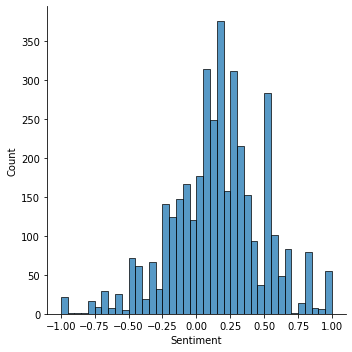

In [33]:
sns.displot(x=final_data['Sentiment'])

We can see that the vast majority of the comments have a sentiment value between -0.25 to 0.75. Both extremes have very less representation. Majority of comments are slightly to moderately positive.

Finally, let's carry out some analysis on word frequency. For that we will use the *spacy* library, which is primary used for Natural Language Processing. It has been loaded already at the top of the notebook.

In [34]:
complete_doc = nlp(str(post_comments))

The *post_comments* list has been converted into a spacy object for further processing.  
  
At first, we are going to find the most commonly used Proper Nouns. That will give us an idea about the main topics of discussion.

In [35]:
words = [token.text for token in complete_doc if not token.is_stop and not token.is_punct and token.pos_ == 'PROPN']

In [36]:
from collections import Counter

In [37]:
word_freq = Counter(words)

In [38]:
common_words = word_freq.most_common(10)

In [39]:
common_words

[('Chelsea', 225),
 ('England', 198),
 ('CL', 163),
 ('City', 145),
 ('United', 136),
 ('Madrid', 134),
 ('France', 124),
 ('Liverpool', 123),
 ('Germany', 112),
 ('Cup', 108)]

The most common word is **Chelsea**, followed by **England** and **CL**. It is understandable, as the major topic of discussion in the footballing world has been the CL(Champions League) triumph by Chelsea, and the upcoming England squad selection for the European Championships.

Finally, we will represent the top 10 positive words by frequency, in a graphical manner.

In [40]:
positive_words = [token.text for token in complete_doc if not token.is_stop and not token.is_punct and TextBlob(str(token)).sentiment.polarity > 0]

In [41]:
positive_freq = Counter(positive_words)

In [42]:
common_positive_words = positive_freq.most_common(10)

In [43]:
common_positive_words

[('good', 448),
 ('better', 303),
 ('best', 254),
 ('win', 212),
 ('right', 196),
 ('great', 141),
 ('lol', 114),
 ('pretty', 105),
 ('winning', 97),
 ('sure', 93)]

In [44]:
type(common_positive_words)

list

In [45]:
a,b = zip(*common_positive_words)

In [46]:
a = np.array(a)
b = np.array(b)

c:\users\hp\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Top 10 frequently used positive words')

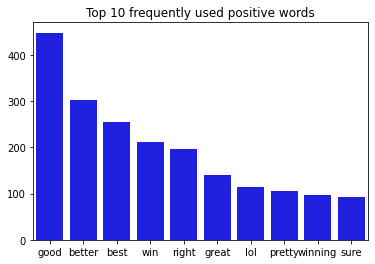

In [47]:
sns.barplot(a,b,color = 'blue').set_title('Top 10 frequently used positive words')